# CutMix 또는 Mixup 비교실험 하기

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1.Augmentation을 적용한 데이터셋 만들기
#### 이전 스텝과 아래 코드를 참고하여 데이터셋에 CutMix 또는 Mixup augmentation을 적용해 주세요.

In [3]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
         ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [4]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [5]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [6]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [7]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []
    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

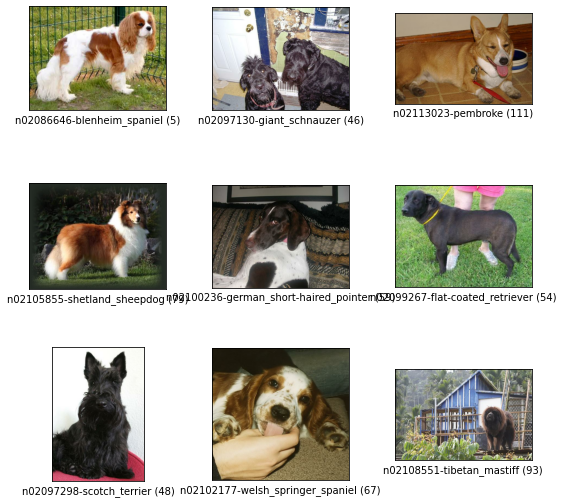

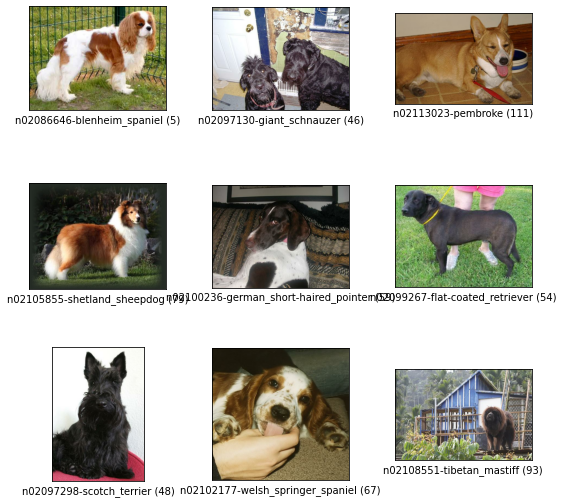

In [8]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
tfds.show_examples(ds_train, ds_info)


 - No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋

 #####  ds_train_no_aug에  각 augmentation 데이터를 합쳐서 학습 진행

In [10]:
num_classes = ds_info.features["label"].num_classes
batch_size = 64

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

# Concatenate ds_train_cutmix and ds_train datasets
ds_train_combined_cut = ds_train_cutmix.concatenate(ds_train_no_aug)
ds_train_combined_mix = ds_train_mixup.concatenate(ds_train_no_aug)
ds_train_combined_aug = ds_train_aug.concatenate(ds_train_no_aug)

buffer_size = 128 # Adjust the buffer size as per your requirements
# datasets shuffle
ds_train_combined_cut = ds_train_combined_cut.shuffle(buffer_size=buffer_size)
ds_train_combined_mix = ds_train_combined_mix.shuffle(buffer_size=buffer_size)
ds_train_combined_aug = ds_train_combined_aug.shuffle(buffer_size=buffer_size)

In [11]:
# def example_show(dataset):
#     fig, axes = plt.subplots(3, 3, figsize=(15, 15))
#     axes = axes.ravel()
#     for images,labels in dataset.take(1):
#         for i in range(9):
#             ax = plt.subplot(3, 3, i + 1)
#             ax.imshow((images[i]).numpy().astype("uint8"))
#             plt.title(labels[i])
#             plt.axis("off")
#     plt.tight_layout()
#     plt.show()

### ds_train_aug

In [12]:
# example_show(ds_train_aug)

### ds_train_mixup

In [13]:
# tfds.show_examples(ds_train_mixup, ds_info)

### ds_train_cutmix

In [14]:
# tfds.show_examples(ds_train_cutmix, ds_info)

### ds_test

In [15]:
# tfds.show_examples(ds_test, ds_info)

## 2. 모델 만들기
## 3. 모델 훈련하기

In [16]:
EPOCH = 50

In [17]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)
history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_combined_cut, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples*2/batch_size),
    validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)
cutmix_resnet50.save('./cutmix_resnet50')

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/50
375/375 [==============================] - 88s 193ms/step - loss: 4.3171 - accuracy: 0.1117 - val_loss: 5.7202 - val_accuracy: 0.0061
Epoch 2/50
375/375 [==============================] - 72s 191ms/step - loss: 3.4008 - accuracy: 0.2992 - val_loss: 3.2400 - val_accuracy: 0.2313
Epoch 3/50
375/375 [==============================] - 72s 191ms/step - loss: 3.0994 - accuracy: 0.3792 - val_loss: 1.6176 - val_accuracy: 0.5681
Epoch 4/50
375/375 [==============================] - 72s 191ms/step - loss: 2.9060 - accuracy: 0.4480 - val_loss: 1.4143 - val_accuracy: 0.6124
Epoch 5/50
375/375 [==============================] - 71s 190ms/step - loss: 2.7881 - accuracy: 0.4770 - val_loss: 1.4172 - val_accuracy: 0.6101
Epoch 6/50
375/375 [==============================] - 71s 190ms/step - loss: 2.6722 - accuracy: 0.5170 - val_loss: 1.2158 - val_accuracy: 0.6535
Epoch 7/50
375/375 [==============================] - 71s 190ms/step - loss: 2.5671 - accuracy: 0.5480 - val_loss: 1.4447 - val_ac

INFO:tensorflow:Assets written to: ./cutmix_resnet50/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [18]:

resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)
history_resnet50 = resnet50.fit(
    ds_train_no_aug, # augmentation 적용한 데이터셋 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)
resnet50.save('./resnet50')

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/50
187/187 [==============================] - 48s 211ms/step - loss: 3.7263 - accuracy: 0.1775 - val_loss: 5.3432 - val_accuracy: 0.0107
Epoch 2/50
187/187 [==============================] - 38s 204ms/step - loss: 2.1565 - accuracy: 0.4241 - val_loss: 5.0581 - val_accuracy: 0.0093
Epoch 3/50
187/187 [==============================] - 38s 204ms/step - loss: 1.6917 - accuracy: 0.5247 - val_loss: 4.9319 - val_accuracy: 0.0098
Epoch 4/50
187/187 [==============================] - 38s 205ms/step - loss: 1.3497 - accuracy: 0.6267 - val_loss: 3.1006 - val_accuracy: 0.2528
Epoch 5/50
187/187 [==============================] - 38s 205ms/step - loss: 0.9797 - accuracy: 0.7269 - val_loss: 2.1695 - val_accuracy: 0.4151
Epoch 6/50
187/187 [==============================] - 38s 205ms/step - loss: 0.7441 - accuracy: 0.8085 - val_loss: 1.3736 - val_accuracy: 0.6091
Epoch 7/50
187/187 [==============================] - 38s 205ms/step - loss: 0.6053 - accuracy: 0.8356 - val_loss: 1.2635 - val_ac

INFO:tensorflow:Assets written to: ./resnet50/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [19]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_combined_mix, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples*2/batch_size),
    validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)
mixup_resnet50.save('./mixup_resnet50')

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/50
375/375 [==============================] - 85s 193ms/step - loss: 4.2508 - accuracy: 0.1247 - val_loss: 6.1529 - val_accuracy: 0.0051
Epoch 2/50
375/375 [==============================] - 71s 190ms/step - loss: 3.3379 - accuracy: 0.3217 - val_loss: 3.3892 - val_accuracy: 0.2076
Epoch 3/50
375/375 [==============================] - 71s 189ms/step - loss: 3.0261 - accuracy: 0.4270 - val_loss: 1.8454 - val_accuracy: 0.5014
Epoch 4/50
375/375 [==============================] - 71s 190ms/step - loss: 2.8798 - accuracy: 0.4708 - val_loss: 1.5838 - val_accuracy: 0.5606
Epoch 5/50
375/375 [==============================] - 71s 190ms/step - loss: 2.7369 - accuracy: 0.5122 - val_loss: 1.6889 - val_accuracy: 0.5331
Epoch 6/50
375/375 [==============================] - 71s 190ms/step - loss: 2.6397 - accuracy: 0.5562 - val_loss: 1.5022 - val_accuracy: 0.5774
Epoch 7/50
375/375 [==============================] - 71s 190ms/step - loss: 2.5711 - accuracy: 0.5845 - val_loss: 1.4823 - val_ac

INFO:tensorflow:Assets written to: ./mixup_resnet50/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [23]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_combined_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)
aug_resnet50.save('./aug_resnet50')

Epoch 1/50
187/187 [==============================] - 50s 209ms/step - loss: 3.8195 - accuracy: 0.1638 - val_loss: 5.4008 - val_accuracy: 0.0103
Epoch 2/50
187/187 [==============================] - 38s 205ms/step - loss: 2.2033 - accuracy: 0.4368 - val_loss: 5.0376 - val_accuracy: 0.0135
Epoch 3/50
187/187 [==============================] - 38s 204ms/step - loss: 1.6847 - accuracy: 0.5237 - val_loss: 4.9683 - val_accuracy: 0.0154
Epoch 4/50
187/187 [==============================] - 38s 205ms/step - loss: 1.3944 - accuracy: 0.6009 - val_loss: 3.6525 - val_accuracy: 0.1754
Epoch 5/50
187/187 [==============================] - 38s 204ms/step - loss: 1.1773 - accuracy: 0.6735 - val_loss: 1.9927 - val_accuracy: 0.4664
Epoch 6/50
187/187 [==============================] - 38s 204ms/step - loss: 1.0621 - accuracy: 0.7005 - val_loss: 1.4242 - val_accuracy: 0.5938
Epoch 7/50
187/187 [==============================] - 38s 205ms/step - loss: 0.9166 - accuracy: 0.7406 - val_loss: 1.5348 - val_ac

INFO:tensorflow:Assets written to: ./aug_resnet50/assets
/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


## 4. 훈련 과정 시각화하기

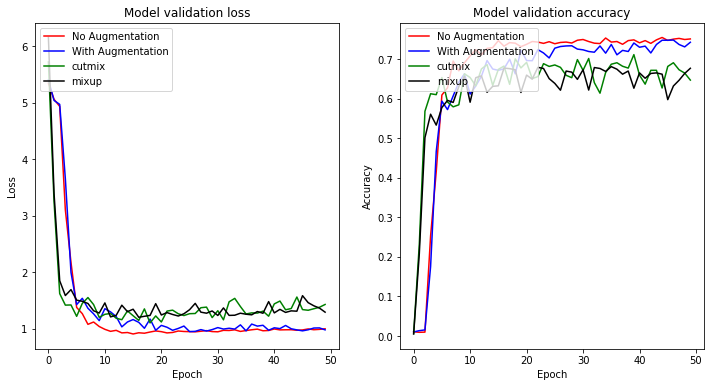

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(history_resnet50.history['val_loss'], 'r')
ax1.plot(history_resnet50_aug.history['val_loss'], 'b')
ax1.plot(history_resnet50_cutmix.history['val_loss'], 'g')
ax1.plot(history_resnet50_mixup.history['val_loss'], 'k')
ax1.set_title('Model validation loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['No Augmentation', 'With Augmentation', 'cutmix', 'mixup'], loc='upper left')

ax2.plot(history_resnet50.history['val_accuracy'], 'r')
ax2.plot(history_resnet50_aug.history['val_accuracy'], 'b')
ax2.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
ax2.plot(history_resnet50_mixup.history['val_accuracy'], 'k')
ax2.set_title('Model validation accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['No Augmentation', 'With Augmentation', 'cutmix', 'mixup'], loc='upper left')


# fig, ax1 = plt.subplots(1, 2, figsize=(12, 6))
plt.show()

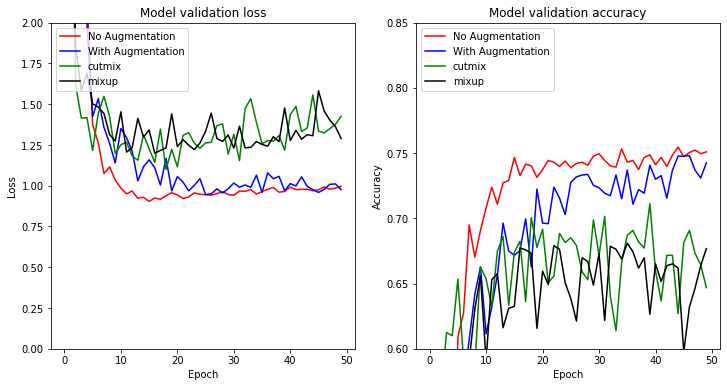

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(history_resnet50.history['val_loss'], 'r')
ax1.plot(history_resnet50_aug.history['val_loss'], 'b')
ax1.plot(history_resnet50_cutmix.history['val_loss'], 'g')
ax1.plot(history_resnet50_mixup.history['val_loss'], 'k')
ax1.set_ylim([0.00, 2]) # <<<<< 
ax1.set_title('Model validation loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend(['No Augmentation', 'With Augmentation', 'cutmix', 'mixup'], loc='upper left')

ax2.plot(history_resnet50.history['val_accuracy'], 'r')
ax2.plot(history_resnet50_aug.history['val_accuracy'], 'b')
ax2.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
ax2.plot(history_resnet50_mixup.history['val_accuracy'], 'k')
ax2.set_ylim([0.60, 0.85]) # <<<
ax2.set_title('Model validation accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend(['No Augmentation', 'With Augmentation', 'cutmix', 'mixup'], loc='upper left')


# fig, ax1 = plt.subplots(1, 2, figsize=(12, 6))
plt.show()

## 5. Augmentation에 의한 모델 성능 비교

데이터를 합치고 50 에폭을 했는데 no aug의 성능이 최고점대비 가장 좋게 나왔으며, 기본 aug가 따라잡으려는 모습을 보였지만 두번째로 좋은 성능을 보였습니다.

그리고 cutmix가 중간에 더 좋은 성능을 보였지만, cutmix와 mixup은 학습을 더 진행할수록  acc가 크게 요동치는 모습을 보여주고 있습니다.

 - 최고 성능 기준 (epoch / val acc)

|No Aug|기본 Aug|Cutmix|Mixup|
|------|--------|------|-----|
| 45 / 0.7547 | 47 / 0.7481 | 40 / 0.7113 | 23 / 0.6791 |

 - 최종 에폭 기준 (epoch / val acc)

|No Aug|기본 Aug|Cutmix|Mixup|
|------|--------|------|-----|
| 50 / 0.7509 | 50 / 0.7425 | 50 / 0.6469 | 50 / 0.6768 |